<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Group Number:
# Student 1:
# Student 2:
# Student 3:

In case you are using google colab, uncomment the following cell, and modify the ```notebook_dir``` variable to contain the directory this notebook is in. It will automatically download the .py files needed for this assignment

In [1]:
# # Change the following  line to the directory this notebook is (if using colab)
# # In case you do not know the path, open the file navigator on the left in colab
# # Find the folder containing this notebook, then press on the three dots --> copy path
# notebook_dir = "/content/drive/MyDrive/Colab Notebooks/"

In [2]:
# # UNCOMMENT IF USING COLAB
# from google.colab import drive
# import requests
# drive.mount('/content/drive')
# import sys
# import os
# sys.path.insert(0, notebook_dir) 
# os.chdir(notebook_dir)
# symco = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/symconv.py?raw=true"
# crpt = "https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/carpet.py?raw=true"
# r_s = requests.get(symco, allow_redirects=True)
# r_c = requests.get(crpt, allow_redirects=True)
# with open('symconv.py', 'wb') as f:
#     f.write(r_s.content)
# with open('carpet.py', 'wb') as f:
#     f.write(r_c.content)

In [3]:
!pip install scipy
!pip install tqdm

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

import io
import requests

import symconv as sc
from carpet import show_carpet, oh_to_label

import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from tqdm import tqdm

In [3]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 

# Task 1: Pattern Classification

In [4]:
# loading training and testing data for task 1
# DO NOT MODIFY
task1 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task1data.npz?raw=true")
# task1 = np.load("task1data.npz")

X = torch.tensor(task1['arr_0']).float()
y = torch.tensor(task1['arr_1']).float()

X_train = X[:7500]
X_val = X[7500:9500]
X_test = X[9500:]
y_train = y[:7500]
y_val = y[7500:9500]
y_test  = y[9500:]

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)
test_dataset = TensorDataset(X_test, y_test)


print(f"Carpet train shape: {X_train.shape}")
print(f"Label train shape: {y_train.shape}")
print(f"Carpet validation shape: {X_val.shape}")
print(f"Label validation shape: {y_val.shape}")
print(f"Carpet test shape: {X_test.shape}")
print(f"Label test shape: {y_test.shape}")

Carpet train shape: torch.Size([7500, 1, 96, 60])
Label train shape: torch.Size([7500, 3])
Carpet validation shape: torch.Size([2000, 1, 96, 60])
Label validation shape: torch.Size([2000, 3])
Carpet test shape: torch.Size([500, 1, 96, 60])
Label test shape: torch.Size([500, 3])


Carpet from Reinforciya


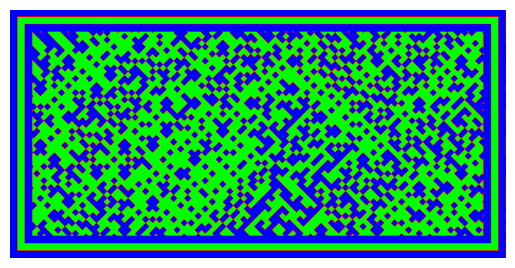

In [5]:
# random carpet
idx = np.random.randint(0,7500)
show_carpet(X_train, idx)
print('Carpet from', oh_to_label(y_train[idx,None])[0])

In [6]:
y_test[0]

tensor([0., 0., 1.])

In [7]:
###     YOUR CODE FOR TASK 1    ###
### ADD MORE CELLS IF NECESSARY ###

In [8]:
from symconv import SymmetryPool, Slice, SymmetryConv2d

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from symconv import SymmetryPool, Slice, SymmetryConv2d

class CarpetOriginCNN(nn.Module):
    def __init__(self, num_classes):
        super(CarpetOriginCNN, self).__init__()
        
        self.slice4 = Slice(rotation=4, reflection=False)
        self.conv1 = SymmetryConv2d(
            in_filters=1,
            out_filters=18,
            kernel_size=4,
            stride=4,
            rotation=4,
            reflection=False
        )

        self.slice1 = Slice(rotation=1, reflection=False)
        self.conv2 = SymmetryConv2d(
            in_filters=18,
            out_filters=12,
            kernel_size=3,
            stride=3,
            rotation=1,
            reflection=False
        )
        
        self.pool = SymmetryPool(pool=torch.amax)  # Use SymmetryPool for pooling
        self.fc1 = nn.Linear(480, 128)  # Adjust the input size
        self.fc2 = nn.Linear(128, num_classes)  # Use num_classes for the output layer

    def forward(self, x):
        x = self.slice4(x)
        x = self.conv1(x)
        x = F.relu(x)
        x = self.pool(x)

        x = self.slice1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        
        x = self.fc1(x)
        x = F.relu(x)
        logits = self.fc2(x)
        return logits

model = CarpetOriginCNN(3) # Three cities: Convolushahr, Transformabad, Reinforciya
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = torch.nn.CrossEntropyLoss()

# Create dataloaders for training and validation
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [12]:
from tqdm import tqdm

# Define a function for training the model with a progress bar
def train_model(model, dataloader, optimizer, loss_fn, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for batch_idx, (inputs, labels) in enumerate(dataloader):
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = loss_fn(outputs, labels[:, 0].long())  # Use the first label for city prediction
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.set_postfix(loss=loss.item())  # Display the current batch loss in the progress bar
                pbar.update()
            
        # Print the average loss for the epoch
        epoch_loss = running_loss / len(dataloader)
        print(f"Epoch [{epoch + 1}/{num_epochs}] Average Loss: {epoch_loss:.4f}")

train_model(model, train_loader, optimizer, loss_fn, 10)

Epoch 1/10: 100%|██████████| 59/59 [00:06<00:00,  8.69batch/s, loss=0.768]


Epoch [1/10] Average Loss: 1.8774


Epoch 2/10: 100%|██████████| 59/59 [00:05<00:00, 11.04batch/s, loss=0.613]


Epoch [2/10] Average Loss: 0.6888


Epoch 3/10: 100%|██████████| 59/59 [00:05<00:00, 11.10batch/s, loss=0.526]


Epoch [3/10] Average Loss: 0.5952


Epoch 4/10: 100%|██████████| 59/59 [00:05<00:00, 11.04batch/s, loss=0.416]


Epoch [4/10] Average Loss: 0.4756


Epoch 5/10: 100%|██████████| 59/59 [00:05<00:00, 10.99batch/s, loss=0.228]


Epoch [5/10] Average Loss: 0.3442


Epoch 6/10: 100%|██████████| 59/59 [00:05<00:00, 11.16batch/s, loss=0.184]


Epoch [6/10] Average Loss: 0.1977


Epoch 7/10: 100%|██████████| 59/59 [00:05<00:00, 10.49batch/s, loss=0.0678]


Epoch [7/10] Average Loss: 0.1136


Epoch 8/10: 100%|██████████| 59/59 [00:05<00:00, 10.90batch/s, loss=0.0465]


Epoch [8/10] Average Loss: 0.0685


Epoch 9/10: 100%|██████████| 59/59 [00:05<00:00, 10.78batch/s, loss=0.032] 


Epoch [9/10] Average Loss: 0.0465


Epoch 10/10: 100%|██████████| 59/59 [00:05<00:00, 10.88batch/s, loss=0.0407]


Epoch [10/10] Average Loss: 0.0462


## Task 1: Question 5d

In [13]:
# Evaluate the model on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels[:, 0].long()).sum().item()  # Use the first label for city prediction

print(f"Validation Accuracy: {100 * correct / total}%")

Validation Accuracy: 99.3%


In [ ]:
# Evaluate the model on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels[:, 0].long()).sum().item()  # Use the first label for city prediction

print(f"test Accuracy: {100 * correct / total}%")

test Accuracy: 99.8%


# Task 2: Carpet Matching 

# loading training and testing data for task 2
# DO NOT MODIFY
task2 = load_numpy_arr_from_url("https://github.com/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/task2data.npz?raw=true")
# task2 = np.load('task2data.npz')

X = task2['arr_0'].astype(float)
y = task2['arr_1'].astype(float)
gt = task2['arr_2'].astype(float) # ground truth
queries = task2['arr_3'].astype(float)
targets = task2['arr_4'].astype(float)

print(f"Carpet train shape: {X.shape}")
print(f"Label train shape: {y.shape}")
print(f"Ground truth test shape: {gt.shape}")
print(f"Query carpets shape: {queries.shape}")
print(f"Candidate carpets shape: {targets.shape}")

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset

# ... (Previous code for data loading and preprocessing)

class CarpetOriginCNN(nn.Module):
    def __init__(self, num_classes):
        super(CarpetOriginCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 12 * 15, 128)  # Adjust the input size
        self.fc2 = nn.Linear(128, num_classes)  # Use num_classes for the output layer

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Initialize the model and optimizer
num_classes = 3  # Three cities: Convolushahr, Transformabad, Reinforciya
model = CarpetOriginCNN(num_classes)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Create dataloaders for training and validation
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Define a function for training the model
def train_model(model, dataloader, optimizer, criterion, num_epochs=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels[:, 0].long())  # Use the first label for city prediction
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(dataloader)}")

# Train the model
train_model(model, train_loader, optimizer, criterion, num_epochs=10)

# Evaluate the model on the validation set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in val_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels[:, 0].long()).sum().item()  # Use the first label for city prediction

print(f"Validation Accuracy: {100 * correct / total}%")


In [ ]:
###     YOUR CODE FOR TASK 2    ###
### ADD MORE CELLS IF NECESSARY ###